# Comparing and Analysing Bookmaker's Odds and Underlying Statistics to the Results of the English Premier League's (EPL) 2016/17 - 2018/2019 Seasons. 

In [1]:
from IPython.display import display_html

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Changes number of decimal points displayed for floats in dataframes
pd.set_option('precision', 3)

import warnings
# Remove warning messages
warnings.filterwarnings('ignore')

# Functions

In [2]:
def team_data(team_name):
# Returns dataframe containing all games played by a single team, home and away
    return matches.loc[matches[['home_team_name', 'away_team_name']].eq(team).any(1), :]

# Source: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
def display_side_by_side(*args):
# Displays tables side by side inline
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


# Data Preprocessing
## Initial Wrangling of the Match Results and Bookmaker's Odds

In [3]:
season_16 = pd.read_csv('EPL16-17.csv')
season_17 = pd.read_csv('EPL17-18.csv')
season_18 = pd.read_csv('EPL18-19.csv')

In [4]:
# Checks if all datasets have the same columns
list(season_16.columns.values) == list(season_17.columns.values), list(season_16.columns.values) == list(season_18.columns.values)

(True, True)

In [5]:
matches = pd.concat([season_16, season_17, season_18])
# Reset index after concatenation so it doesn't repeat
matches.reset_index(inplace=True)

In [6]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 55 columns):
index                                  1140 non-null int64
timestamp                              1140 non-null int64
date_GMT                               1140 non-null object
status                                 1140 non-null object
attendance                             1130 non-null float64
home_team_name                         1140 non-null object
away_team_name                         1140 non-null object
Pre-Match PPG (Home)                   1140 non-null float64
Pre-Match PPG (Away)                   1140 non-null float64
home_ppg                               1140 non-null float64
away_ppg                               1140 non-null float64
home_team_goal_count                   1140 non-null int64
away_team_goal_count                   1140 non-null int64
total_goal_count                       1140 non-null int64
total_goals_at_half_time               1140 non-null 

There are missing values in the attendance and goal timing columns. Goal timing would be due to 0-0 results, attendance due to lack of reporting

In [7]:
matches.rename(columns={'date_GMT': 'Date'}, inplace=True)

In [8]:
# Check if Date is in str or datetime format
type(matches['Date'].iloc[0])

str

In [9]:
# Converts date column to 'datetime' format
matches.loc[:, 'Date'] = pd.to_datetime(matches['Date'], infer_datetime_format=True)

# All matches are taken from the English Premier League, rendering 'Div' redundant
cols = list(matches.columns)
# Result cols contains a list of column names related to the match statistics
result_cols = cols[1:33]
# Odds cols contains a list of column names related to the bookmaker's odds 
odds_cols = cols[45:48]
# Removes unnecessary columns
matches = matches[result_cols + odds_cols]
matches.drop(['status', 'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'timestamp'], axis=1, inplace=True)

In [10]:
matches.head()

,Date,attendance,home_team_name,away_team_name,home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,...,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win
0,2016-08-13 11:30:00,21037.0,Hull City,Leicester City,1.47,0.53,2,1,3,1,...,15,4,6,7,9,7,17,3.41,3.19,2.39
1,2016-08-13 14:00:00,19126.0,Burnley,Swansea City,1.74,0.74,0,1,1,0,...,15,6,8,6,7,10,14,2.45,3.22,3.26
2,2016-08-13 14:00:00,24490.0,Crystal Palace,West Bromwich Albion,1.05,0.84,0,1,1,0,...,12,7,6,5,6,12,14,2.20,3.25,3.80
3,2016-08-13 14:00:00,39494.0,Everton,Tottenham Hotspur,2.26,1.74,1,1,2,1,...,6,7,4,3,2,10,14,3.13,3.36,2.45
4,2016-08-13 14:00:00,32110.0,Middlesbrough,Stoke City,0.95,0.89,1,1,2,1,...,10,3,2,5,8,18,13,2.49,3.20,3.21


In [11]:
matches[matches[odds_cols].eq(0).all(axis=1)]

,Date,attendance,home_team_name,away_team_name,home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,...,away_team_shots,home_team_shots_on_target,away_team_shots_on_target,home_team_shots_off_target,away_team_shots_off_target,home_team_fouls,away_team_fouls,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win
84,2016-10-22 14:00:00,31969.0,Leicester City,Crystal Palace,1.79,1.11,3,1,4,1,...,24,4,8,11,16,10,7,0.0,0.0,0.0
245,2017-02-11 15:00:00,56983.0,West Ham United,West Bromwich Albion,1.32,0.84,2,2,4,1,...,7,6,4,6,3,7,13,0.0,0.0,0.0
618,2018-01-20 15:00:00,20886.0,Swansea City,Liverpool,1.11,1.68,1,0,1,1,...,24,4,13,2,11,5,9,0.0,0.0,0.0


3 columns have a '0' value on their odds, suggesting NaN values (suggests £0 return per £1 placed). Convert all values to '1' 

In [12]:
matches.loc[[84, 245, 618], odds_cols] = 1

### Converting Bookmaker's Odds to 'Implied Likelihood'

As betting odds represent the potential return on investment, the implied favourite will have lower odds. Calculate likelihoods by the following equation:

Event Odds = A / B

P(event) = B / (A + B)


In [13]:
# Convert bettings odds to a probability, and then *100 to return a percentage
matches.loc[:, odds_cols] = 1/(matches[odds_cols] + 1) * 100
matches.loc[:, odds_cols].head()

,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win
0,22.676,23.866,29.499
1,28.986,23.697,23.474
2,31.250,23.529,20.833
3,24.213,22.936,28.986
4,28.653,23.810,23.753


In [14]:
# Shorten column names for ease as they will be used frequently in this project
matches.rename(columns={'odds_ft_home_team_win': 'odds_home_win', 'odds_ft_draw': 'odds_draw', 'odds_ft_away_team_win': 'odds_away_win'}, inplace=True);

## Feature engineering

### Home favourite and W/D/L dummies

These will provide clear binary classifications for whether the bookmaker's favourite and the actual result. While these can be derived from the data, having them as separate columns improves clarity of the data

In [15]:
# Creates new column containing Boolean values for whether Home Team is favoured by Bookmakers.
matches.loc[:, 'home_fav'] = matches['odds_home_win'] > matches['odds_away_win'] # Why does this raise warning when below does not?

matches.loc[:, 'away_fav'] = matches['odds_away_win'] > matches['odds_home_win']
 
# Creates new column containing Boolean values for whether Home Team wins the game.
matches.loc[:, 'home_win'] = matches['home_team_goal_count'] > matches['away_team_goal_count']

# Creates new column containing Boolean values for whether Away Team wins the game
matches.loc[:, 'away_win'] = matches['home_team_goal_count'] < matches['away_team_goal_count']

# For a 'draw' both Home and Away win will be False

# Full Time Result
matches.loc[:, 'goal_diff'] = matches['home_team_goal_count'] - matches['away_team_goal_count']
matches.loc[:, 'result'] = 0
matches.loc[:, 'result'].where(matches['goal_diff'] < 0.5, 'H', inplace=True)
matches.loc[:, 'result'].where(matches['goal_diff'] > -0.5, 'A', inplace=True)
matches.loc[:, 'result'].where(matches['goal_diff'] != 0, 'D', inplace=True)


matches[['home_team_name', 'away_team_name', 'home_team_goal_count', 'away_team_goal_count', 'goal_diff', 'result']]

,home_team_name,away_team_name,home_team_goal_count,away_team_goal_count,goal_diff,result
0,Hull City,Leicester City,2,1,1,H
1,Burnley,Swansea City,0,1,-1,A
2,Crystal Palace,West Bromwich Albion,0,1,-1,A
3,Everton,Tottenham Hotspur,1,1,0,D
4,Middlesbrough,Stoke City,1,1,0,D
...,...,...,...,...,...,...
1135,Manchester United,Cardiff City,0,2,-2,A
1136,Liverpool,Wolverhampton Wanderers,2,0,2,H
1137,Watford,West Ham United,1,4,-3,A
1138,Fulham,Newcastle United,0,4,-4,A


## Prior Performance

### Points Per Game

Create a 'Points Per Game' (PPG) column, displaying a cumulative mean of the teams prior results. The current PPG columns include performances dating further back than the data available for this project. An additional PPG column that displays only the 'recent' PPG will be more indicative of the current team's performance. As teams change their players and tactics often, PPG from 5 seasons ago is less relevant than more recent results.

In [16]:
# Creates list of all teams in DF
teams = list(matches['home_team_name'].unique())
len(teams)

26

There are 20 individual teams per EPL season. Each season, 3 teams are relegated to the Championship and 3 are promoted. Over three seasons there have been 26 teams, meaning no team that has been relegated has been re-promoted 

In [17]:
# Home vs Away points mapping for final results
home_ppm = {'H': 3, 'D': 1, 'A': 0}
away_ppm = {'H': 0, 'D': 1, 'A': 3}

# Create 'empty' columns for filling
matches.loc[:, 'HPPG'] = 0
matches.loc[:, 'APPG'] = 0

# Iterates through list of all teams in database
for i, team in enumerate(teams):
    # Returns home games for selected team and gives numerical value to win/loss/draw
    home_games = matches[matches['home_team_name'] == team]
    home_games.loc[:, 'home_pts'] = home_games['result'].map(home_ppm)
    # Returns away games for selected team
    away_games = matches[matches['away_team_name'] == team]
    away_games.loc[:, 'away_pts'] = away_games['result'].map(away_ppm)
    
    # Combines home and away games for selected team and sorts by date 
    overall_games = pd.concat([home_games, away_games])
    overall_games.sort_index(inplace=True)

    # Creates 'Points Per Match' column. A cumulative mean for each team
    team_pts = overall_games['home_pts'].fillna(0) + overall_games['away_pts'].fillna(0)
    rolling_count = overall_games.reset_index().index.values
    ppg = team_pts.cumsum() / (rolling_count + 1)
    overall_games.loc[:, 'HPPG'] = ppg.where(overall_games['home_team_name'] == team)
    overall_games.loc[:, 'APPG'] = ppg.where(overall_games['away_team_name'] == team)

    # Converts back into separate home and away DFs so only the correct rows are updated
    home_games = overall_games[overall_games['home_team_name'] == team]
    away_games = overall_games[overall_games['away_team_name'] == team]
    
    # Updates the PPM columns for selected teams index only
    matches.loc[home_games.index.values, 'HPPG'] = home_games.loc[:, 'HPPG']
    matches.loc[away_games.index.values, 'APPG'] = away_games.loc[:, 'APPG']

### Avg Goals Scored / Conceded / Difference

Add further 'lagged' features for more in-depth performance stats.

In [18]:
matches.columns.values

array(['Date', 'attendance', 'home_team_name', 'away_team_name',
       'home_ppg', 'away_ppg', 'home_team_goal_count',
       'away_team_goal_count', 'total_goal_count',
       'total_goals_at_half_time', 'home_team_goal_count_half_time',
       'away_team_goal_count_half_time', 'home_team_goal_timings',
       'away_team_goal_timings', 'home_team_corner_count',
       'away_team_corner_count', 'home_team_yellow_cards',
       'home_team_red_cards', 'away_team_yellow_cards',
       'away_team_red_cards', 'home_team_shots', 'away_team_shots',
       'home_team_shots_on_target', 'away_team_shots_on_target',
       'home_team_shots_off_target', 'away_team_shots_off_target',
       'home_team_fouls', 'away_team_fouls', 'odds_home_win', 'odds_draw',
       'odds_away_win', 'home_fav', 'away_fav', 'home_win', 'away_win',
       'goal_diff', 'result', 'HPPG', 'APPG'], dtype=object)

In [19]:
# Creates Columns for average goals scored, conceded and difference
# Uses the cumulative sum of the previous games divided by the number of games played to get the mean average
for team in teams:
    # Returns home games for selected team and ignores home vs away, merging all goals scored for vs against
    home_games = matches[matches['home_team_name'] == team]
    home_games.loc[:, 'teams_goals'] = home_games['home_team_goal_count']
    home_games.loc[:, 'opponents_goals'] = home_games['away_team_goal_count']
    home_games.loc[:, 'goal_diff'] = home_games['teams_goals'] - home_games['opponents_goals']
    home_games.loc[:, 'shots_on_target'] = home_games['home_team_shots_on_target']
    # Returns away games for selected team
    away_games = matches[matches['away_team_name'] == team]
    away_games.loc[:, 'teams_goals'] = away_games['away_team_goal_count']
    away_games.loc[:, 'opponents_goals'] = away_games['home_team_goal_count']
    away_games.loc[:, 'goal_diff'] = away_games['teams_goals'] - away_games['opponents_goals']
    away_games.loc[:, 'shots_on_target'] = away_games['away_team_shots_on_target']
    
    # Combines home and away games for selected team and sorts by date 
    overall_games = pd.concat([home_games, away_games])
    overall_games.sort_index(inplace=True)    

    # Rolling count provides a count for each match to then divide the sum of all previous games for a mean average
    rolling_count = overall_games.reset_index().index.values
    avg_team_goals = overall_games['teams_goals'].cumsum() / (rolling_count + 1)
    avg_opp_goals = overall_games['opponents_goals'].cumsum() / (rolling_count + 1)
    avg_goal_diff = overall_games['goal_diff'].cumsum() / (rolling_count + 1)
    avg_shots_on_target = overall_games['shots_on_target'].cumsum() / (rolling_count + 1)

    # Splits each of the above series to home and away games
    overall_games.loc[:, 'avg_home_goals_scored'] = avg_team_goals.where(overall_games['home_team_name'] == team)
    overall_games.loc[:, 'avg_away_goals_scored'] = avg_team_goals.where(overall_games['away_team_name'] == team)
    
    overall_games.loc[:, 'avg_home_goals_conceded'] = avg_opp_goals.where(overall_games['home_team_name'] == team)
    overall_games.loc[:, 'avg_away_goals_conceded'] = avg_opp_goals.where(overall_games['away_team_name'] == team)
    
    overall_games.loc[:, 'avg_home_goal_diff'] = avg_goal_diff.where(overall_games['home_team_name'] == team)
    overall_games.loc[:, 'avg_away_goal_diff'] = avg_goal_diff.where(overall_games['away_team_name'] == team)
    
    overall_games.loc[:, 'avg_home_shots_on_target'] = avg_shots_on_target.where(overall_games['home_team_name'] == team)
    overall_games.loc[:, 'avg_away_shots_on_target'] = avg_shots_on_target.where(overall_games['away_team_name'] == team)
    
    # Converts back into separate home and away DFs so only the correct rows are updated
    home_games = overall_games[overall_games['home_team_name'] == team]
    away_games = overall_games[overall_games['away_team_name'] == team]
    
    # Update columns in the dataframe
    matches.loc[home_games.index.values, 'avg_home_goals_scored'] = home_games.loc[:, 'avg_home_goals_scored']
    matches.loc[home_games.index.values, 'avg_home_goals_conceded'] = home_games.loc[:, 'avg_home_goals_conceded']
    matches.loc[home_games.index.values, 'avg_home_goal_diff'] = home_games.loc[:, 'avg_home_goal_diff']
    matches.loc[home_games.index.values, 'avg_home_shots_on_target'] = home_games.loc[:, 'avg_home_shots_on_target']


    matches.loc[away_games.index.values, 'avg_away_goals_scored'] = away_games.loc[:, 'avg_away_goals_scored']
    matches.loc[away_games.index.values, 'avg_away_goals_conceded'] = away_games.loc[:, 'avg_away_goals_conceded']
    matches.loc[away_games.index.values, 'avg_away_goal_diff'] = away_games.loc[:, 'avg_away_goal_diff']
    matches.loc[away_games.index.values, 'avg_away_shots_on_target'] = away_games.loc[:, 'avg_away_shots_on_target']


### Team Form (Last 5 Games)

Team form over the last 5 games (points gained) highlights recent performance even more than PPG.

In [20]:
for team in teams:
    # Returns home games for selected team and gives numerical value to win/loss/draw
    home_games = matches[matches['home_team_name'] == team]
    home_games.loc[:, 'team_pts'] = home_games['result'].map(home_ppm)
    # Returns away games for selected team
    away_games = matches[matches['away_team_name'] == team]
    away_games.loc[:, 'team_pts'] = away_games['result'].map(away_ppm)
    
    # Combines home and away games for selected team and sorts by date 
    overall_games = pd.concat([home_games, away_games])
    overall_games.sort_index(inplace=True)
    
    # Sum of team's points from the last 5 games
    form = overall_games['team_pts'].shift(1) + overall_games['team_pts'].shift(2) + overall_games['team_pts'].shift(3) + overall_games['team_pts'].shift(4) + overall_games['team_pts'].shift(5)
    overall_games.loc[:, 'form'] = form
    
    home_games = overall_games[overall_games['home_team_name'] == team]
    away_games = overall_games[overall_games['away_team_name'] == team]
    
    matches.loc[home_games.index.values, 'home_form'] = home_games.loc[:, 'form']
    matches.loc[away_games.index.values, 'away_form'] = away_games.loc[:, 'form']


### Team Ratings

Elo is a rating system for a variety of games that provides a 'score' for win/loss depending on the opponent's ELO. To simplify the system, as this data is only covering a short time period, the mean average of each teams ELO is taken and applied to them for every match to give a general indication to the team's strength.

In [21]:
elo = pd.read_csv('ELO_Ratings.csv')
# Returns only English games from elo csv
elo = elo[elo['country'] == 'England']
elo.head()

,date,country,team,rating
17351,13/08/2016,England,Manchester City,993.0
17352,13/08/2016,England,Sunderland,755.0
17357,13/08/2016,England,Southampton,894.0
17358,13/08/2016,England,Watford,692.0
17359,13/08/2016,England,Hull City,681.0


In [22]:
for team in teams:
    elo_rating = elo[elo['team'] == team]['rating'].mean()
    # Returns home games for selected team and fills column with elo_rating
    home_games = matches[matches['home_team_name'] == team]
    # Returns away games for selected team
    away_games = matches[matches['away_team_name'] == team]
    
    matches.loc[home_games.index.values, 'home_elo'] = elo_rating
    matches.loc[away_games.index.values, 'away_elo'] = elo_rating

matches[matches['home_elo'].isna()].head()

,Date,attendance,home_team_name,away_team_name,home_ppg,away_ppg,home_team_goal_count,away_team_goal_count,total_goal_count,total_goals_at_half_time,...,avg_home_goal_diff,avg_home_shots_on_target,avg_away_goals_scored,avg_away_goals_conceded,avg_away_goal_diff,avg_away_shots_on_target,home_form,away_form,home_elo,away_elo
764,2018-08-11 14:00:00,24821.0,Fulham,Crystal Palace,1.11,1.53,0,2,2,1,...,-2.000,7.000,1.260,1.532,-0.273,4.831,NaN,13.0,NaN,713.216
766,2018-08-11 16:30:00,31231.0,Wolverhampton Wanderers,Everton,1.79,1.05,2,2,4,2,...,0.000,5.000,1.403,1.351,0.052,4.948,NaN,8.0,NaN,817.709
770,2018-08-18 11:30:00,30720.0,Cardiff City,Newcastle United,1.05,1.05,0,0,0,0,...,-1.000,2.000,1.000,1.225,-0.225,4.950,NaN,3.0,NaN,713.200
780,2018-08-25 11:30:00,31322.0,Wolverhampton Wanderers,Manchester City,1.79,2.32,1,1,2,0,...,-0.667,3.667,2.468,0.861,1.608,7.595,NaN,13.0,NaN,1077.341
788,2018-08-26 15:00:00,23438.0,Fulham,Burnley,1.11,0.89,4,2,6,5,...,-0.667,8.000,0.987,1.278,-0.291,4.203,NaN,2.0,NaN,735.459


Elo ratings are unavailable for newly promoted teams. Fill missing values with min

In [23]:
elo_min = matches['home_elo'].min()
matches['home_elo'].fillna(elo_min, inplace=True)
matches['away_elo'].fillna(elo_min, inplace=True)

## Exploratory Analysis

### What feature is most correlated to winning?

As is seen below, bookmaker's odds are more correlated to a win than almost all features in this dataset. The only statistic more correlated with winning is the number of goals the team scored at half time, information that is unknown before the start of the game, when the bookmaker's have to make their predictions. This indicated the bookmaker's use additional data in their predictions than what is available in this dataset.

Despite the success of the bookmaker's predictions, other features are still highly correlated such as points per game, average home goals scored and conceded, as well as ELO.

Attendance provides an interesting correlation. Stadium attendance is positively correlated to a home win, negatively correlated to an away win. Suggesting the '12th man' phenomenon may hold true: more home fans attending a match increases the teams chance of winning.

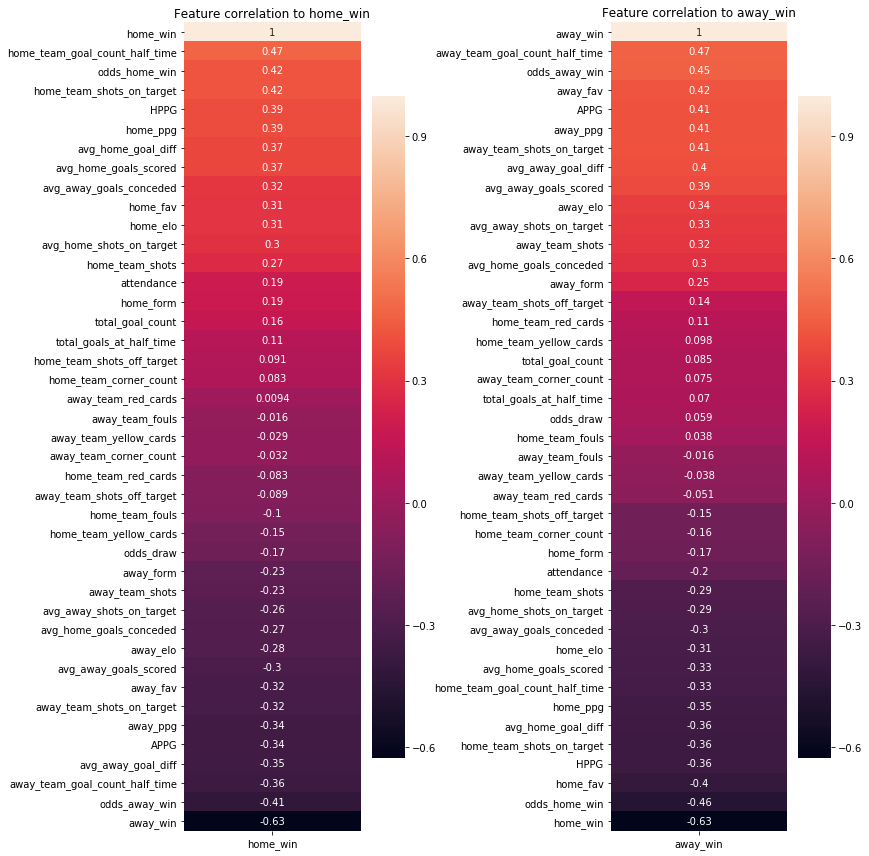

In [24]:
# Creates correlation matrix between each feature
corr_matches = matches.drop(['home_team_goal_count', 'away_team_goal_count', 'goal_diff'], axis=1)
corr_matches = corr_matches.corr()
plt.figure(figsize=(12, 12))

# Create plots for home and away wins compared to just home or away wins (1 column of the matrix)
plt.subplot(1, 2, 1)
plt.title('Feature correlation to home_win')
sns.heatmap(corr_matches[['home_win']].sort_values(by='home_win', ascending=False), annot=True)
plt.subplot(1, 2, 2)
plt.title('Feature correlation to away_win')
sns.heatmap(corr_matches[['away_win']].sort_values(by='away_win', ascending=False), annot=True)

plt.tight_layout()

### What feature is most correlated with bookmaker's odds?

Bookmaker's odds have similar correlations with features as the wins do, suggesting these features are indicative of a teams chance of winning. The correlations with the actual results are more modest than the correlations with the bookmaker's odds. These features are likely to be very indicative of how the bookmaker's set their odds. Match results have more variance than how bookmaker's set their odds, which these statistics explain. 

Recent points per game (HPPG/APPG) have greater correlation to the result than more long term points per game (home/away_ppg).

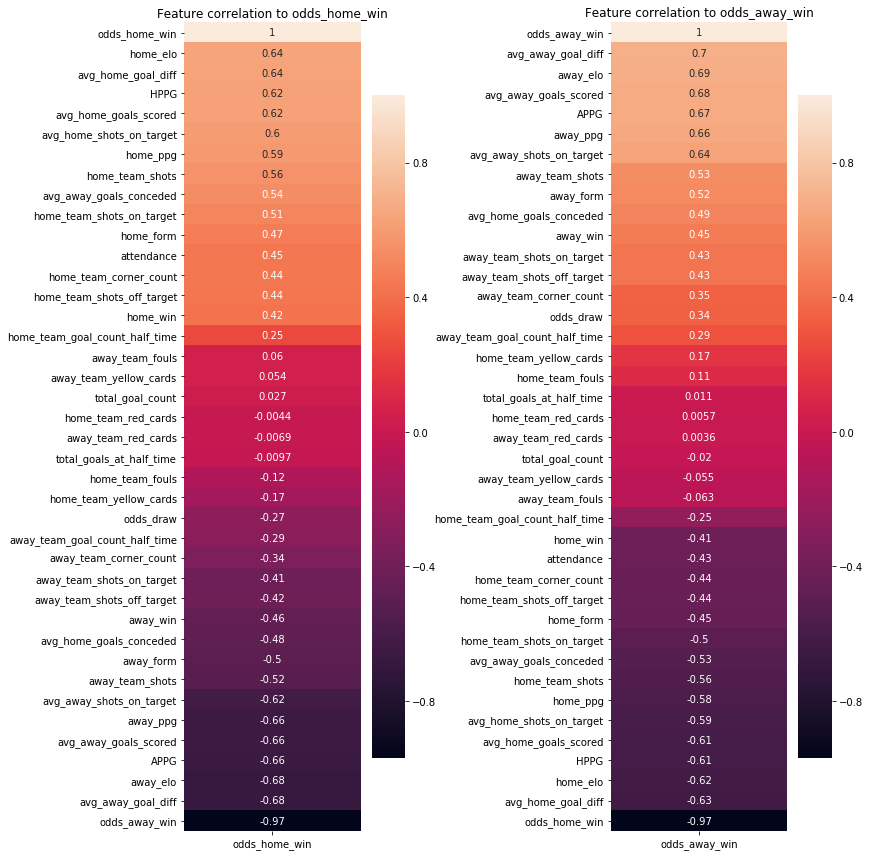

In [25]:
# Creates correlation matrix between each feature
corr_matches = matches.drop(['home_team_goal_count', 'away_team_goal_count', 'goal_diff', 'home_fav', 'away_fav'], axis=1)
corr_matches = corr_matches.corr()
plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 1)
plt.title('Feature correlation to odds_home_win')
sns.heatmap(corr_matches[['odds_home_win']].sort_values(by='odds_home_win', ascending=False), annot=True)
plt.subplot(1, 2, 2)
plt.title('Feature correlation to odds_away_win')
sns.heatmap(corr_matches[['odds_away_win']].sort_values(by='odds_away_win', ascending=False), annot=True)

plt.tight_layout()

### Exploring Home Bias in Bookmaker Predictions

Home advantages are a well documented phenomenon in sports, with the crowd in football often being nicknamed 'the twelfth man'. 

In [26]:
matches[['odds_home_win','odds_draw', 'odds_away_win']].describe()

,odds_home_win,odds_draw,odds_away_win
count,1140.000,1140.000,1140.000
mean,30.032,19.809,22.999
std,10.699,4.354,10.698
min,4.348,5.970,2.286
25%,23.767,17.279,14.169
50%,30.769,21.097,22.297
75%,38.314,22.883,29.963
max,50.000,50.000,50.000


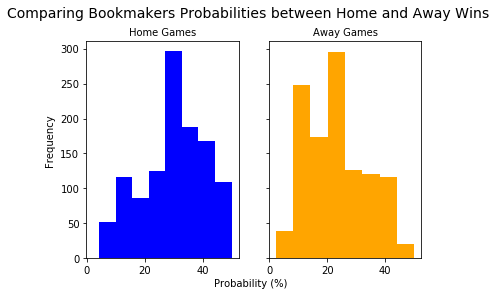

In [27]:
# Creates figure with two frequency histograms 
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.hist(matches['odds_home_win'], bins=8, color='blue')
ax2.hist(matches['odds_away_win'], bins=8, color='orange')
# Title for entire figure
fig.suptitle('Comparing Bookmakers Probabilities between Home and Away Wins', y=1, fontsize=14)
fig.text(0.42, 0.03, 'Probability (%)', fontsize=10)
fig.text(0.03, 0.6, 'Frequency', fontsize=10, rotation='vertical')
ax1.set_title('Home Games', fontsize=10)
ax2.set_title('Away Games', fontsize=10);

Bookmakers, on average, give the home team a 30% probability of a win, while giving away teams a mean of of 23%. This suggests playing at home is assumed to have a larger advantage. This is highlighted further by the right skew in the distribution of Home Team probabilities, while Away Team probability distribution is left skewed. Generally, bookmakers give teams a higher chance of winning when playing at home.

### Bookmaker Predictions Compared to Actual Results

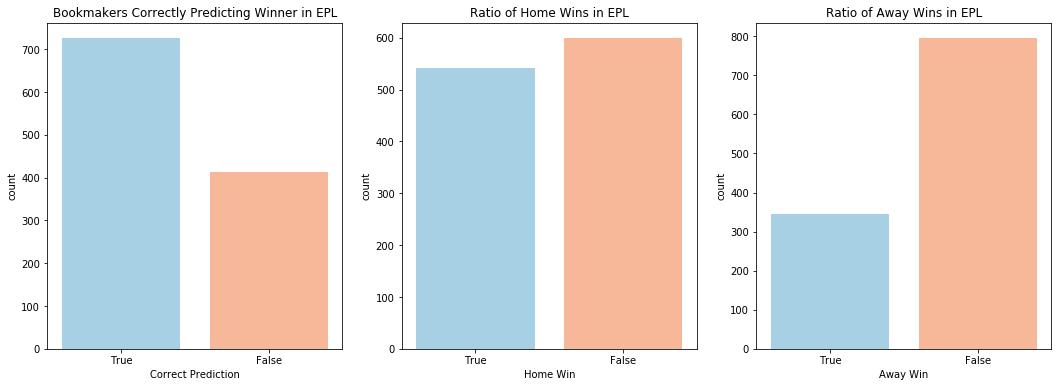

In [28]:
# Creates variable evaluating whether Bookmakers favoured the Winning Team.
correct_fav = matches['home_fav'] == matches['home_win']

plt.figure(figsize=(18, 6))

# Creates 'count plot' visualising the correct predictions from the Bookmaker's
plt.subplot(1, 3, 1)
sns.countplot(correct_fav, palette='RdBu_r', order=correct_fav.value_counts().index, saturation=1) # Orders descendingly
plt.xlabel('Correct Prediction')
plt.title('Bookmakers Correctly Predicting Winner in EPL');

# Creates 'count plot' visualising the ratio of Home vs Away wins
plt.subplot(1, 3, 2)
sns.countplot(matches['result'] == 'H', palette='RdBu_r', order=matches['home_win'].value_counts(ascending=True).index, saturation=1) # Orders descendingly
plt.title('Ratio of Home Wins in EPL')
plt.xlabel('Home Win');

plt.subplot(1, 3, 3)
sns.countplot(matches['result'] == 'A', palette='RdBu_r', order=matches['away_win'].value_counts(ascending=True).index, saturation=1) # Orders descendingly
plt.title('Ratio of Away Wins in EPL')
plt.xlabel('Away Win');

Bookmakers correctly predicted the winner ~65% of the time. Home teams won just less than half the games, while away teams lost 70% of the time, suggesting Home Teams do have a significant advantage.

### Comparing PPG and ELO to Bookmakers favourites

In [29]:
# Correlation coeffiecient for both home and away elo and ppg
stats.pearsonr(matches['home_elo'], matches['home_ppg']), stats.pearsonr(matches['away_elo'], matches['away_ppg'])

((0.8258559724676863, 2.0329382394074134e-285),
 (0.83220149271562, 9.76271044698753e-294))

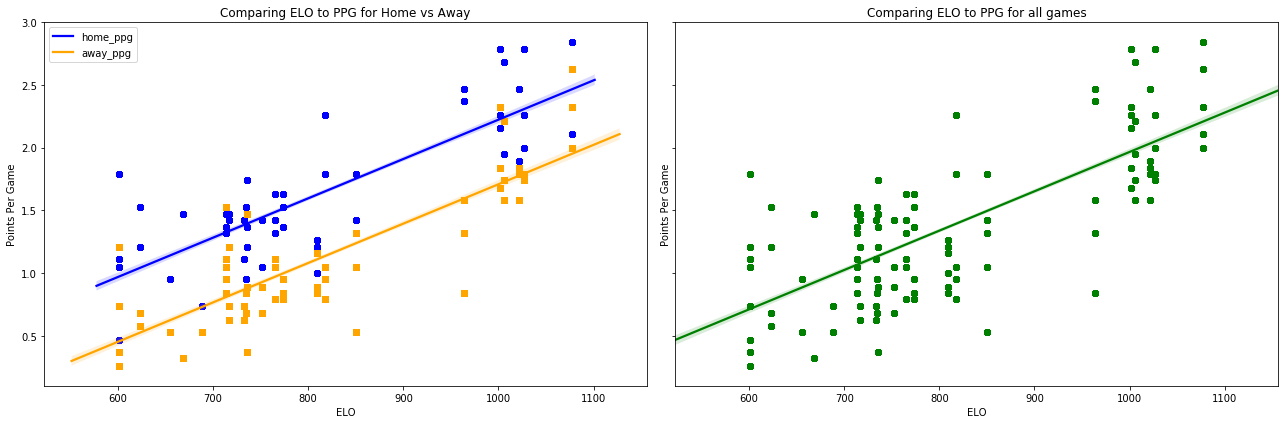

In [30]:
# Creates two regression plots on the same figure for both home and away
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), sharex=True, sharey=True)
sns.regplot(matches['home_elo'], matches['home_ppg'], ax=ax1, marker='o', color='b')
sns.regplot(matches['away_elo'], matches['away_ppg'], ax=ax1, marker='s', color='orange')
ax1.set_title('Comparing ELO to PPG for Home vs Away')
ax1.set_xlabel('ELO')
ax1.set_ylabel('Points Per Game')
ax1.legend(['home_ppg', 'away_ppg'])

all_elo = pd.concat([matches['home_elo'], matches['away_elo']])
all_ppg = pd.concat([matches['home_ppg'], matches['away_ppg']])

# Combines the above into one regression plot
sns.regplot(all_elo, all_ppg, ax=ax2, marker='o', color='g')
ax2.set_title('Comparing ELO to PPG for all games')
ax2.set_xlabel('ELO')
ax2.set_ylabel('Points Per Game')

fig.tight_layout()


The above graph shows ELO, a team's ability rating, compared to PPG. While both are indicators of a team's performance, it demonstrates that teams of similar ability perform better at their home ground. As both regression lines have the same gradient, teams with a higher ELO generally outperform weaker teams regardless of home advantage.

As both home and away games have a correlation coefficient of ~0.83, it suggests there is a strong correlation between teams strength and the points they score per game.

### How Do Teams Perform Against Different Opponents?
How do teams perform with against different elo ranges? Do poor elo teams play well against high elo teams? do mid elo perform better against high elo or low?

Organising elo ratings into categories is easier for comparison to bookmaker's odds

count    2280.000
mean      816.041
std       145.279
min       601.257
25%       715.953
50%       769.202
75%       973.430
max      1077.341
dtype: float64

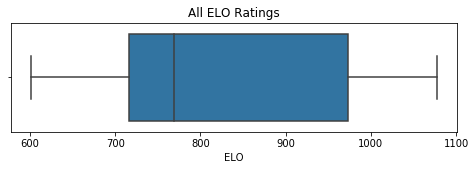

In [31]:
plt.figure(figsize=(8, 2))
sns.boxplot(all_elo)
plt.title('All ELO Ratings')
plt.xlabel('ELO')
all_elo.describe()

Team Strength will be categorised as follows:

0-25% = Weak teams

25-75% = Average teams

75-100% = Strong teams

In [32]:
weak = all_elo.quantile(0.25)
strong = all_elo.quantile(0.75)

# Fills home and away strength based on whether ELO is greater than the quartile
matches.loc[matches['home_elo'] <= weak, 'home_strength'] = 'weak'
matches.loc[matches['home_elo'] >= strong, 'home_strength'] = 'strong'
matches.loc[matches['away_elo'] <= weak, 'away_strength'] = 'weak'
matches.loc[matches['away_elo'] >= strong, 'away_strength'] = 'strong'

# Fills all values within interquartile range
matches.loc[:, 'home_strength'].fillna('average', inplace=True)
matches.loc[:, 'away_strength'].fillna('average', inplace=True)

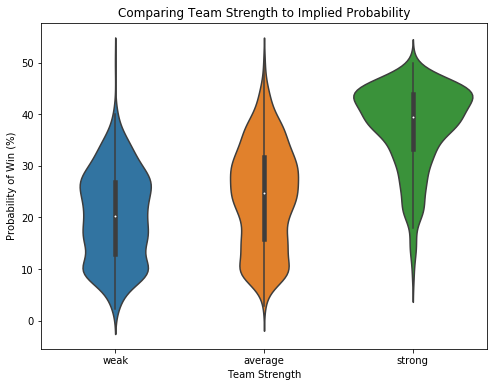

In [33]:
# Combine home and away strength / odds to cover all games
strength = pd.concat([matches['home_strength'], matches['away_strength']])
odds = pd.concat([matches['odds_home_win'], matches['odds_away_win']])

plt.figure(figsize=(8, 6))
sns.violinplot(strength, odds)
plt.title('Comparing Team Strength to Implied Probability')
plt.xlabel('Team Strength')
plt.ylabel('Probability of Win (%)');

The data suggests that Bookmaker's use team strength as a metric, whether some form of ELO or PPG (as they are highly correlated). A team with an exceptionally high ELO (the upper quartile) is highly correlated to a greater win probability, with less regard for opposition strength. The wider spread for the weak and average teams could be explained by the greater range in opponents they can face. An average team can face much weaker opponents (lowest ELO) and much stronger opponents (highest ELO). A team with an ELO in the upper quartile, won't face drastically better teams, leading to a higher median win percentage.

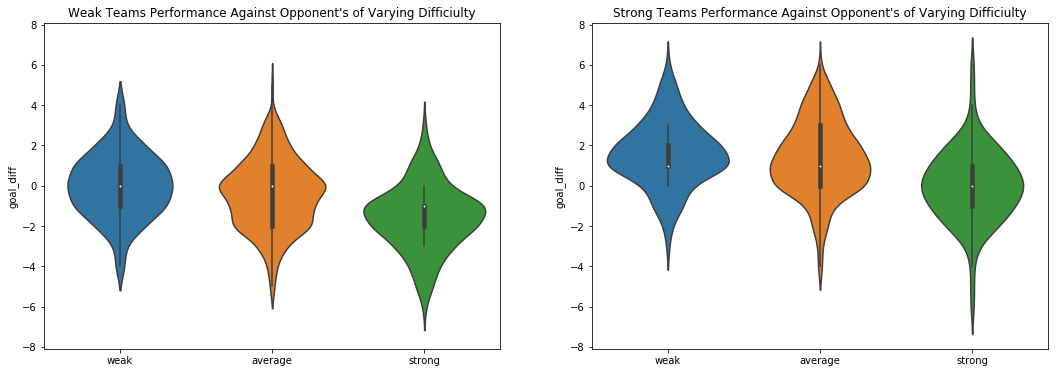

In [34]:
# Create Violin Plot for both weak and strong team performances against all opponents

# Concatenates the feeatures looked at to ignore whether team is home or away
weak_home_teams = matches[matches['home_strength'] == 'weak']
weak_away_teams = matches[matches['away_strength'] == 'weak']
weak_opponent_strength = pd.concat([weak_home_teams['away_strength'], weak_away_teams['home_strength']], ignore_index=True)
# Inverse of away goal difference to show relative goal difference of target teams
weak_goal_diff = pd.concat([weak_home_teams['goal_diff'], - weak_away_teams['goal_diff']], ignore_index=True)

# Concatenates the feeatures looked at to ignore whether team is home or away
strong_home_teams = matches[matches['home_strength'] == 'strong']
strong_away_teams = matches[matches['away_strength'] == 'strong']
strong_opponent_strength = pd.concat([strong_home_teams['away_strength'], strong_away_teams['home_strength']], ignore_index=True)
# Inverse of away goal difference to show relative goal difference of target teams
strong_goal_diff = pd.concat([strong_home_teams['goal_diff'], - strong_away_teams['goal_diff']], ignore_index=True)

# Create violinplots next to each other for comparison
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), sharex=True, sharey=True)
ax1.set_title('Weak Teams Performance Against Opponent\'s of Varying Difficiulty')
sns.violinplot(weak_opponent_strength, weak_goal_diff, ax=ax1, order=['weak', 'average', 'strong'])

ax2.set_title('Strong Teams Performance Against Opponent\'s of Varying Difficiulty')
sns.violinplot(strong_opponent_strength, strong_goal_diff, ax=ax2)
# Shows y labels on both plots even with sharey True
ax2.yaxis.set_tick_params(which='both', labelleft=True)


The above graph shows that weak teams perform almost equally well against weak and average teams, while they suffer against strong teams. Strong teams have an all round better performance against all opponents, with a much greater likelihood of winning against weaker opponents.

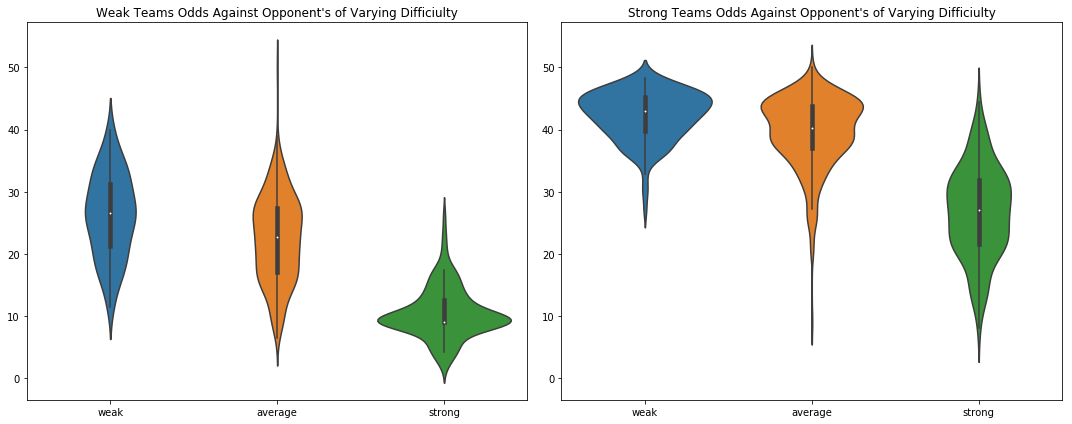

In [35]:
# Creates graphs as above but comparing varying opponent strengths to bookmaker implied likelihoods

weak_win_odds = pd.concat([weak_home_teams['odds_home_win'], weak_away_teams['odds_away_win']], ignore_index=True)
strong_win_odds = pd.concat([strong_home_teams['odds_home_win'], strong_away_teams['odds_away_win']], ignore_index=True)

# Create violinplots next to each other for comparison
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6), sharex=True, sharey=True)
ax1.set_title('Weak Teams Odds Against Opponent\'s of Varying Difficiulty')
sns.violinplot(weak_opponent_strength, weak_win_odds, ax=ax1, order=['weak', 'average', 'strong'])

ax2.set_title('Strong Teams Odds Against Opponent\'s of Varying Difficiulty')
sns.violinplot(strong_opponent_strength, strong_win_odds, ax=ax2)
# Shows y labels on both plots even with sharey True
ax2.yaxis.set_tick_params(which='both', labelleft=True)

plt.tight_layout()

In [36]:
# Shows overall win probabilites for weak teams, as well as win probabilities against varying opponents
weak_odds = pd.DataFrame({'odds': weak_win_odds, 'opponent_strength': weak_opponent_strength})
display_side_by_side(weak_odds.describe(),
                     weak_odds[weak_odds['opponent_strength'] == 'weak'].rename(columns={'odds': 'odds_vs_weak'}).describe(),
                     weak_odds[weak_odds['opponent_strength'] == 'average'].rename(columns={'odds': 'odds_vs_average'}).describe(), 
                     weak_odds[weak_odds['opponent_strength'] == 'strong'].rename(columns={'odds': 'odds_vs_strong'}).describe())

,odds
count,570.000
mean,20.180
std,8.630
min,2.286
25%,12.903
50%,20.284
75%,26.936
max,50.000
,odds_vs_weak
count,132.000


In [37]:
# Shows overall win probabilites for strong teams, as well as win probabilities against varying opponents
strong_odds = pd.DataFrame({'odds': strong_win_odds, 'opponent_strength': strong_opponent_strength})
display_side_by_side(strong_odds.describe(),
                     strong_odds[strong_odds['opponent_strength'] == 'weak'].rename(columns={'odds': 'odds_vs_weak'}).describe(),
                     strong_odds[strong_odds['opponent_strength'] == 'average'].rename(columns={'odds': 'odds_vs_average'}).describe(), 
                     strong_odds[strong_odds['opponent_strength'] == 'strong'].rename(columns={'odds': 'odds_vs_strong'}).describe())

,odds
count,570.000
mean,37.604
std,8.020
min,8.163
25%,33.223
50%,39.526
75%,43.860
max,50.000
,odds_vs_weak
count,150.000


Bookmaker's implied likelihood against various opponents mirrors the actual goal difference of the games, albeit more extreme. The similarities suggest that the bookmakers are accurate in their predictions, but skew the odds in favour of the better teams, potentially to protect against losses.

### Recent Form as an Indicator of Future Performance

Form acts as an indicator of how a team is playing over a shorter period. While it does not guarantee results, teams often go on streaks of either winning or losing. There should be a positive correlation between a teams form and winning future matches. 

In [38]:
matches.columns.values

array(['Date', 'attendance', 'home_team_name', 'away_team_name',
       'home_ppg', 'away_ppg', 'home_team_goal_count',
       'away_team_goal_count', 'total_goal_count',
       'total_goals_at_half_time', 'home_team_goal_count_half_time',
       'away_team_goal_count_half_time', 'home_team_goal_timings',
       'away_team_goal_timings', 'home_team_corner_count',
       'away_team_corner_count', 'home_team_yellow_cards',
       'home_team_red_cards', 'away_team_yellow_cards',
       'away_team_red_cards', 'home_team_shots', 'away_team_shots',
       'home_team_shots_on_target', 'away_team_shots_on_target',
       'home_team_shots_off_target', 'away_team_shots_off_target',
       'home_team_fouls', 'away_team_fouls', 'odds_home_win', 'odds_draw',
       'odds_away_win', 'home_fav', 'away_fav', 'home_win', 'away_win',
       'goal_diff', 'result', 'HPPG', 'APPG', 'avg_home_goals_scored',
       'avg_home_goals_conceded', 'avg_home_goal_diff',
       'avg_home_shots_on_target', 'avg_away_

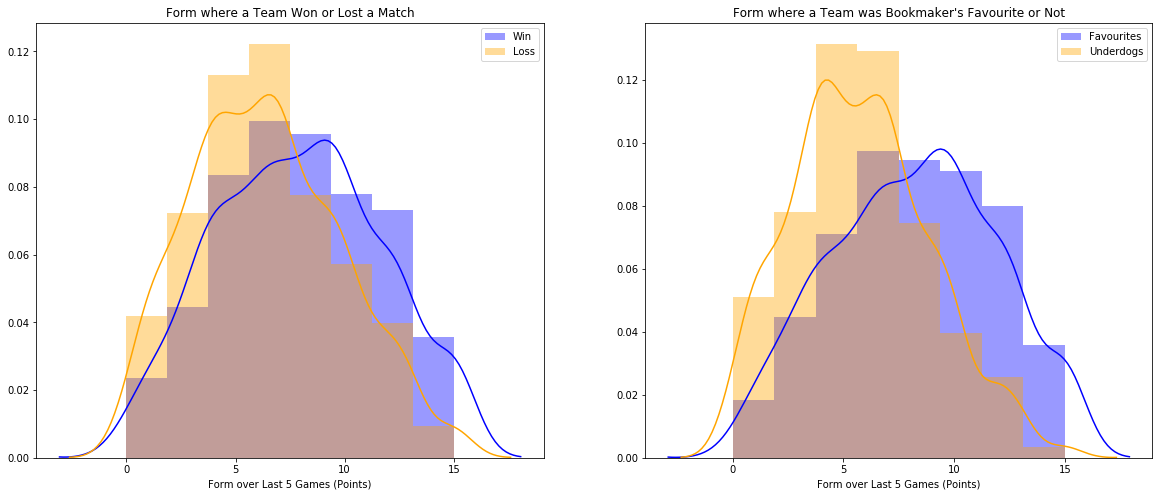

In [39]:
form = pd.concat([matches['home_form'], matches['away_form']], ignore_index=True)
win = pd.concat([matches['home_win'], matches['away_win']], ignore_index=True)
favourites = pd.concat([matches['home_fav'], matches['away_fav']], ignore_index=True)

# Returns index positions for games won
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Form where a Team Won or Lost a Match')
sns.distplot(form.iloc[win[win == True].index.values].dropna(), bins=8, label='Win', color='blue')
sns.distplot(form.iloc[win[win==False].index.values].dropna(), bins=8, label='Loss', color='orange')
plt.legend()
plt.xlabel('Form over Last 5 Games (Points)')

plt.subplot(1, 2, 2)
plt.title('Form where a Team was Bookmaker\'s Favourite or Not')
sns.distplot(form.iloc[favourites[favourites == True].index.values].dropna(), bins=8, label='Favourites', color='blue')
sns.distplot(form.iloc[favourites[favourites==False].index.values].dropna(), bins=8, label='Underdogs', color='orange')
plt.legend()
plt.xlabel('Form over Last 5 Games (Points)');

Bookmaker's favourites has an almost identical distribution to the win/loss distirbution. This indicates they use form as an indicator for which team will win without being too dependent on the feature. The bookmaker's favourites have a form slightly skewed either side; the favourites have a higher average form, while the underdog has a slightly lower form than the actual winners and losers respectively.

In [40]:
# Returns the describe() function for each of the above distributions
form_df = pd.DataFrame({'form': form, 'win': win, 'fav': favourites}).reset_index()
form_df.drop(['index'], axis=1, inplace=True)

display_side_by_side(form_df[form_df['win'] == True].rename(columns={'form': 'Winner\'s Form'}).describe(), 
                     form_df[form_df['win'] == False].rename(columns={'form': 'Loser\'s Form (Including Draws)'}).describe(), 
                     form_df[form_df['fav'] == True].rename(columns={'form': 'Favourite\'s Form'}).describe(), 
                     form_df[form_df['fav'] == False].rename(columns={'form': 'Underdog\'s Form'}).describe())

,Winner's Form
count,837.000
mean,7.909
std,3.769
min,0.000
25%,5.000
50%,8.000
75%,10.000
max,15.000
,Loser's Form (Including Draws)
count,1313.000


# Predictions

## Base Predictions

Bookmakers odds are continuous from a scale of 0 - 100. Linear regression can be used on features that indicate prior performance to estimate how bookmaker's will set their odds. Match statistics cannot be used as they would not be available before the game starts. Forecasting requires 'lagged' features that show previous performance. 

In [41]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# All lagged features except bookmaker's odds which will be used as the target variable
X = matches[['attendance', 'home_ppg', 'away_ppg', 'HPPG', 'APPG', 'avg_home_goals_scored',
       'avg_home_goals_conceded', 'avg_home_goal_diff',
       'avg_home_shots_on_target', 'avg_away_goals_scored',
       'avg_away_goals_conceded', 'avg_away_goal_diff',
       'avg_away_shots_on_target', 'home_form', 'away_form', 'home_elo',
       'away_elo']]
# Fill form at the start of the 
X.fillna(0, inplace=True)

y1 = matches['odds_home_win']
y2 = matches['odds_away_win']

In [42]:
# Create train test splits for both target variables
# Random state for reproducibility
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=1)

In [43]:
# Fit linear regression and returns interecept and coefficients
reg1 = LinearRegression()
reg1.fit(X1_train, y1_train)
reg1.intercept_, reg1.coef_

(29.700161120730144,
 array([ 3.07677817e-05,  2.13045290e+00, -3.83648042e+00, -1.96227429e+00,
        -6.55461181e-01,  1.49743986e+00,  4.49120922e-02,  1.45252776e+00,
         8.42642863e-01, -1.44345334e+00, -2.24002245e-01, -1.21945109e+00,
        -5.23307243e-01,  2.35500209e-01, -8.11010304e-02,  2.04802015e-02,
        -1.89306942e-02]))

In [44]:
y1_pred = reg1.predict(X1_test)

In [45]:
from sklearn import metrics
# Returns RMSE normalised by the mean
np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)) / y1_test.mean()

0.11659660691482333

In [46]:
# Returns r2 score
metrics.r2_score(y1_test, y1_pred)

0.8894155473783136

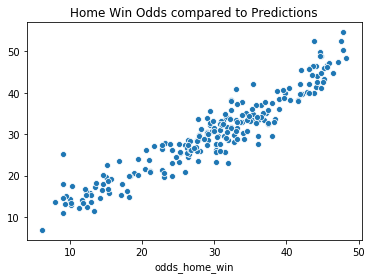

In [47]:
# Comparing Predictions to Actual odds
sns.scatterplot(y1_test, y1_pred)
plt.title('Home Win Odds compared to Predictions');

The model shows high accuracy for predicting what odds the bookmakers will give each team based on their past results and the opponent they are facing. A normalised RMSE of 10% suggests a low error rate. The graph contains some outliers. As football is a game of high variance, outliers could be affecting the accuracy, even if outlying games are part of the sport.

In [1]:
reg2 = LinearRegression()
reg2.fit(X2_train, y2_train)
reg2.intercept_, reg2.coef_

NameError: name 'LinearRegression' is not defined

In [49]:
y2_pred = reg2.predict(X2_test)

In [50]:
np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)) / y2.mean()

0.15786121230789837

In [51]:
metrics.r2_score(y2_test, y2_pred)

0.8781199962887409

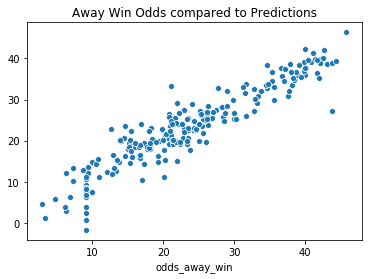

In [52]:
sns.scatterplot(y2_test, y2_pred)
plt.title('Away Win Odds compared to Predictions');

Odds for the away team are slightly harder to predict than the home games. This could be due to the bookmaker's home bias which leads to home odds having a slightly shorter interquartile range, as shown below. A smaller range in values decreases the error in prediction, as values are less likely to vary.

In [53]:
matches['odds_home_win'].quantile(0.75) - matches['odds_home_win'].quantile(0.25), matches['odds_away_win'].quantile(0.75) - matches['odds_away_win'].quantile(0.25)

(14.5468679034343, 15.793226009198682)

## Model with Outliers Removed

Removing Outliers may improve the regression model, as larger outliers greatly affect RMSE. While outliers are part of the game and still need to be predicted, it is interesting to see how much they affect accuracy.

In [54]:
# Bookmaker's odds included for outliers
X = matches[['attendance', 'home_ppg', 'away_ppg', 'HPPG', 'APPG', 'avg_home_goals_scored',
       'avg_home_goals_conceded', 'avg_home_goal_diff',
       'avg_home_shots_on_target', 'avg_away_goals_scored',
       'avg_away_goals_conceded', 'avg_away_goal_diff',
       'avg_away_shots_on_target', 'home_form', 'away_form', 'home_elo',
       'away_elo', 'odds_home_win', 'odds_away_win']]
X.fillna(0, inplace=True)

y1 = matches['odds_home_win']
y2 = matches['odds_away_win']


In [55]:
features = list(X.columns.values)

# Create Z score for each feature in X
for feature in features:
    X.loc[:, feature + ' zScore'] = (X[feature] - X[feature].mean()) / X[feature].std()

# Returns outliers as value '1'
# Anything over 2.5 z score considered an outlier. Using a z score above 2 removes too much data
X.loc[:, 'isOutlier'] = 0
for feature in features:
    i = X[X['isOutlier'] == 0].index.values
    X.loc[i, 'isOutlier'] = (X[feature + ' zScore'].abs() > 2.5).astype(int)

In [56]:
X.isOutlier.value_counts()

0    1058
1      82
Name: isOutlier, dtype: int64

In [57]:
X = X[X['isOutlier'] != 1]
X.iloc[:, 17]

3       24.213
15      23.981
17      25.445
20      29.326
22      28.090
         ...  
1135    43.860
1136    43.103
1137    31.250
1138    27.778
1139     6.154
Name: odds_home_win, Length: 1058, dtype: float64

In [58]:
# First y variable = odds of home win
y1 = X.iloc[:, 17]
# Second y variable = odds of away win
y2 = X.iloc[:, 18]
X = X.iloc[:, 0:17]

In [59]:
# Random state parameter keeps the train and test splits at the same indices
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=1)

In [60]:
reg1 = LinearRegression()
reg1.fit(X1_train, y1_train)
reg1.intercept_, reg1.coef_

(30.457908177247177,
 array([ 3.33786224e-05,  1.26097948e+00, -3.69472412e+00, -2.84092580e-01,
        -3.04499100e+00,  1.94673575e+00,  1.56034809e-01,  1.79070095e+00,
         1.10310256e+00, -1.33761005e+00, -2.45905217e-01, -1.09170483e+00,
        -3.86347869e-01,  1.92385315e-01, -2.76428334e-02,  1.44507147e-02,
        -1.52433284e-02]))

In [61]:
y1_pred = reg1.predict(X1_test)
np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)) / y1_pred.mean()

0.10385838272672787

Text(0.5, 1.0, 'Home Win Odds compared to Predictions with Outliers Removed')

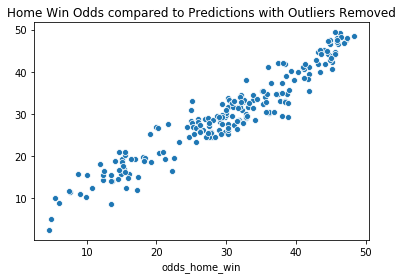

In [62]:
sns.scatterplot(y1_test, y1_pred)
plt.title('Home Win Odds compared to Predictions with Outliers Removed')

In [63]:
metrics.r2_score(y1_test, y1_pred)

0.9162290559932128

In [64]:
reg2 = LinearRegression()
reg2.fit(X2_train, y2_train)
reg2.intercept_, reg2.coef_

(17.35193618627331,
 array([-3.25223663e-05, -1.32528782e+00,  3.37007406e+00,  2.44664856e-01,
         2.92769537e+00, -1.56714263e+00,  4.20610459e-01, -1.98775308e+00,
        -9.86626391e-01,  1.84788526e+00,  7.20083526e-01,  1.12780174e+00,
         4.11707146e-01, -1.79148248e-01,  4.19143142e-02, -1.28023549e-02,
         1.62416391e-02]))

In [65]:
y2_pred = reg2.predict(X2_test)

In [66]:
np.sqrt(metrics.mean_squared_error(y2_test, y2_pred)) / y2_pred.mean()

0.142069791668605

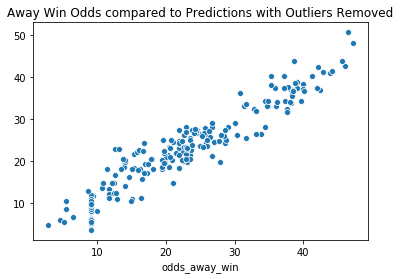

In [67]:
sns.scatterplot(y2_test, y2_pred)
plt.title('Away Win Odds compared to Predictions with Outliers Removed');

In [68]:
metrics.r2_score(y2_test, y2_pred)

0.9046945674605188

The accuracy improves slightly with outliers being removed, however outliers are part of football. Accuracy including outliers could be improved by using a larger dataset. If the model can be trained with more matches, it will have more experience with matches that are currently classed as 'outliers' and should more accurately predict the bookmaker's odds. 

The accuracy is still high considering most variables are just taking the average prior performance. This suggests that bookmaker's use quite generalisable odds. As this data does not include player information, it is possible this could improve the accuracy even further. A team may perform much better when their players are all fit and in form. If their main goalscorer is injured, that is likely to affect odds set by the bookmaker's. 

## Predicting Match Outcomes

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier(n_estimators=2000, random_state=0)

In [71]:
X1 = matches[['attendance', 'home_ppg', 'away_ppg', 'HPPG', 'APPG', 'avg_home_goals_scored',
       'avg_home_goals_conceded', 'avg_home_goal_diff',
       'avg_home_shots_on_target', 'avg_away_goals_scored',
       'avg_away_goals_conceded', 'avg_away_goal_diff',
       'avg_away_shots_on_target', 'home_form', 'away_form', 'home_elo',
       'away_elo']]
X1.fillna(0, inplace=True)
y = matches['result']
#y = matches['home_win']
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, random_state=1)

In [72]:
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [73]:
metrics.confusion_matrix(y_test, preds)

array([[ 60,  13,  24],
       [ 16,   7,  38],
       [ 11,  11, 105]], dtype=int64)

In [74]:
metrics.accuracy_score(y_test, preds)

0.6035087719298246

In [75]:
mapping = {'odds_home_win': 'H', 'odds_away_win': 'A', 'odds_draw': 'D'}
# Maps the column name with the highest value for each row
matches.loc[:, 'Favourite'] =  matches[['odds_home_win', 'odds_away_win', 'odds_draw']].idxmax(axis=1)
# Maps bookmakers highest odds as H/A/D for classification
y_bookies = matches.loc[y_test.index.values, 'Favourite'].map(mapping)

In [76]:
# Actual results compared to bookmaker's favourites
metrics.accuracy_score(y_test, y_bookies)

0.5964912280701754

In [77]:
# Bookmakers predictions compared to model predictions
metrics.accuracy_score(y_bookies, preds)

0.7473684210526316

In [78]:
# Accuracy if every event was classified as a Home win
home_only = ['H'] * len(y_test)
metrics.accuracy_score(home_only, y_test)

0.4456140350877193

The model slightly beats bookmaker's favourites in a classification problem, however it is only by <1%. Bookmakers do not usually favour draws and are more focused on their own profit margins than their predictions. Comparing bookmaker's predictions to the models suggests that this model is more closely linked to bookmakers than it is to the actual results. This makes sense as both bookmaker's and this model's predictions are based off statistics. Football matches have high variability as it is a low scoring game; often, the result won't match the performance. 

Regardless, the model's accuracy is better than classifying every problem as a home win (the most frequent result) as well as being greater than the bookmaker's odds. Although it beats the bookmaker's odds, that does not mean it is profitable. The bookmakers set their odds to increase profitability, not perfectly correlated to likelihood. Further experiments would be needed to prove this.

### Tuned Model

In [79]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [200, 500, 1000],
               'max_features': ['auto', 'sqrt', None],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'min_samples_split': [2, 5, 10, 20],
               'min_samples_leaf': [1, 5, 10, 30],
               'bootstrap': [True, False],   
               
              }
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, random_state=1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=2000,
                                                    n_jobs=N

In [80]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

In [81]:
tuned_preds = rf_random.predict(X_test)

In [82]:
metrics.confusion_matrix(tuned_preds, y_test)

array([[ 61,  18,  10],
       [ 10,   5,   8],
       [ 26,  38, 109]], dtype=int64)

In [83]:
metrics.accuracy_score(tuned_preds, y_test)

0.6140350877192983

With tuning, the model reaches an accuracy of 61.4%. Almost 2% better than the bookmaker's implied predictions.

## Accuracy with High Certainty

Random Forest returns probabilities (each tree's classification). High probability classifications are likely to be more accurate than ones that are close to a coinflip (0.51 : 0.49)

In [84]:
# Stores probabilities for each classification for each row
probs = rf_random.predict_proba(X_test)

In [85]:
decisions = []
for prob in probs:
    prob = prob >= 0.69
    prob = sum(prob)
    decisions.append(prob)

In [86]:
# Returns indicies of values with high certainty
indices = [i for i, x in enumerate(decisions) if x == 1]

In [87]:
preds[indices]

array(['H', 'H', 'A', 'A', 'H', 'H', 'H', 'A', 'H', 'H', 'H', 'A', 'H',
       'A', 'H', 'H', 'H', 'A', 'H', 'H', 'A', 'A', 'H', 'A', 'H', 'H',
       'A', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'H', 'H', 'H',
       'H', 'H', 'H', 'H', 'H', 'A', 'A', 'H', 'H', 'H', 'H', 'H', 'A',
       'A', 'H', 'A', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'A', 'H',
       'H', 'A', 'A', 'A', 'A', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'H',
       'H'], dtype=object)

In [88]:
y_test.iloc[indices]

546    H
841    H
111    A
204    A
304    H
      ..
768    H
815    H
948    A
754    H
487    H
Name: result, Length: 79, dtype: object

In [89]:
metrics.accuracy_score(preds[indices], y_test.iloc[indices])

0.8987341772151899

In [90]:
# Percentage of classifications that have ~90% accuracy
len(indices) / len(y_test)

0.2771929824561403